## Explaining deep LSTM models for detecting anomalies in time-series data (R&D Project)

### Jithin Sasikumar

### LRP

This notebook describes the implementation of **Layer-wise Relevance Propogation (LRP)** which is a **gradient based attribution method** for `LSTM regression models` trained on `time-series data` along with their issues and limitations. It contains data pre-processing, model summary, LRP implementation. My observations are also documented.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
from numpy.random import seed
import time
import tensorflow as tf
import pickle
import h5py
import hickle as hkl

### Data Loading and Pre-processing

The data is a time-series sensor data obtained from NASA vibrational sensors. The data has 4 bearing sensor data as `features - [Bearing 1, Bearing 2, Bearing 3, Bearing 4]` for a time frame as `982 data instances` in total. It is the same data used for SHAP and LIME [3].

**Dataset:** <br>
https://www.kaggle.com/vinayak123tyagi/bearing-dataset

In [2]:
dir = "/data/bearing_data1"
dataset = pd.DataFrame()

for filename in os.listdir(dir):
    data = pd.read_csv(os.path.join(dir, filename), sep='\t')
    dataset_mean_abs = np.array(data.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    dataset = dataset.append(dataset_mean_abs)
    
dataset.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']

dataset.index = pd.to_datetime(dataset.index, format='%Y.%m.%d.%H.%M.%S')
dataset = dataset.sort_index()
dataset.to_csv('Bearing_Dataset.csv')
print("Dataset shape:", dataset.shape)
dataset.head(15)

Dataset shape: (982, 4)


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659
2004-02-12 11:42:39,0.061231,0.074172,0.082022,0.043840
2004-02-12 11:52:39,0.062280,0.075808,0.084372,0.044272
2004-02-12 12:02:39,0.059890,0.075115,0.084506,0.043974
2004-02-12 12:12:39,0.062371,0.075505,0.082238,0.044171
2004-02-12 12:22:39,0.060837,0.074648,0.080552,0.043602


In [3]:
#train-Test Split
train_data = dataset['2004-02-12 10:52:39': '2004-02-16 00:32:39']
test_data = dataset['2004-02-16 00:32:39':]

from sklearn.preprocessing import MinMaxScaler
mean = dataset[['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']].mean(axis=1).astype(float)
y = np.array(mean['2004-02-12 10:52:39': '2004-02-16 00:32:39'])

#Data Normalization
scaler = MinMaxScaler()
X_train_transformed = scaler.fit_transform(train_data)
y_train_transformed = scaler.fit_transform(y.reshape(-1,1))
X_test_transformed = scaler.transform(test_data)

#Transforming data into sequences as 3D input.
X_train = X_train_transformed.reshape(X_train_transformed.shape[0], 1, X_train_transformed.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test_transformed.reshape(X_test_transformed.shape[0], 1, X_test_transformed.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (515, 1, 4)
Test data shape: (468, 1, 4)


### Simple/Vanilla Bi-Directional LSTM

1. `Bi-directional LSTM` train two LSTMs on the input sequence in both the directions (i.e.) It reads the input sequence in normal order and also in reverse order. <br>
2. LRP implementation currently supports only bi-directional LSTM, thus bi-directional LSTM layer followed by a dense layer is used to create a model.

In [4]:
bidi_lstm_model = tf.keras.models.load_model('models/bidi_model.h5')
bidi_lstm_model.summary()

def weight_params(model):
    weights = model.get_weights()
    print("Length of Weight matrix:",len(weights))
    for i in range(len(weights)):
        print(weights[i].shape)
    return weights

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1, 4)]            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 1, 8)              288       
_________________________________________________________________
flatten_3 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 36        
Total params: 324
Trainable params: 324
Non-trainable params: 0
_________________________________________________________________


### LRP Implementation [1]

1. LRP is a gradient based attribution method that assigns a `relevance score` (or) value to each input feature of the neural network. It highlights which input features is used to support the model prediction by propagating from the model prediction backward to the input using set of propogation rules. <br>
2. LRP implementation is done using [1].
3. The same [1] implementation is tweaked in order to apply it for `LSTM regression models` trained on time series data for `anomaly detection`.
4. LRP calculates relevance scores for every input features that makes a prediction. For that, `weight matrix` is used.
5. **Weight matrix** is obtained from keras model as below. It is a list of numpy arrays corresponding to the parameters of the network.
6. The model weight parameters are used in the LRP implementation.
7. Weight matrix includes two matrices `W_x, W_h` and `bias b`. Thus, for one LSTM layer the weight matrix generate $3$ values `(W_x, W_h, b)` and as our model is `bi-directional`, it is doubled with weights in backward direction => `3*2 = 6`. [1]
8. The shapes of `W_x and W_h` are `(Input dimension, 4 * number of hidden units)` and `(number of hidden units, 4 * number of LSTM units)` respectively.  Thus the shape of `W_x` is $(4,16)$ and `W_h` is $(4,16)$ for our model.
9. `W_x, W_h` corresponds to the `LSTM gates (Input Gate, Forget Gate, Cell Gate, Output Gate)` [1] [2].
10. `Dense layer` also produces weight matrix and bias. Thus the total weight matrix of bi-directional model = `8 (3+3+2)`.

**Note:** Input and Flatten layer doesn't update or calculate any weights. Thus, they are empty.

In [5]:
#Get weight matrix of our model
weights_bidi_lstm = weight_params(bidi_lstm_model)

Length of Weight matrix: 8
(4, 16)
(4, 16)
(16,)
(4, 16)
(4, 16)
(16,)
(8, 4)
(4,)


The weight matrix will be fed into the LRP implementation class as below.


In [8]:
from lstm_network import LSTM_network
n_hidden = 4
input_dim = 4
n_classes = 4

In [9]:
start_time_lrp = time.time()
lrp_model = LSTM_network(n_hidden, input_dim, n_classes, weights_bidi_lstm)
y_keras = bidi_lstm_model.predict(X_test)
y_lrpnet, _, _ = lrp_model.full_pass(X_test)

#Explain the model prediction
eps = 1e-3
bias_factor = 0.0
explanation, Rest = lrp_model.lrp(X_test, eps=eps, bias_factor=bias_factor)
end_time_lrp = time.time()
time_lrp = end_time_lrp - start_time_lrp

In [11]:
print("Explanation Shape:",explanation.shape)
explanations = np.array(explanation).reshape(explanation.shape[0], explanation.shape[2])
print("Explanation Shape 2D:", explanations.shape)
#Printing first five relevance scores
print(explanations[0:5])

Explanation Shape: (468, 1, 4)
Explanation Shape 2D: (468, 4)
[[-0.00876236  0.15871977  0.189553    0.04007363]
 [-0.01758092  0.17021763  0.20281746  0.05014113]
 [-0.05143513  0.16911735  0.20908944  0.05669065]
 [-0.01065943  0.16581808  0.18491664  0.03845059]
 [-0.00096363  0.16209056  0.19767263  0.04542753]]


In [2]:
print("Time for LRP to fit bi-directional LSTM: {0} seconds".format(round(time_lrp,3)))

Time for LRP to fit bi-directional LSTM: 2.967 seconds


### LRP Visualization

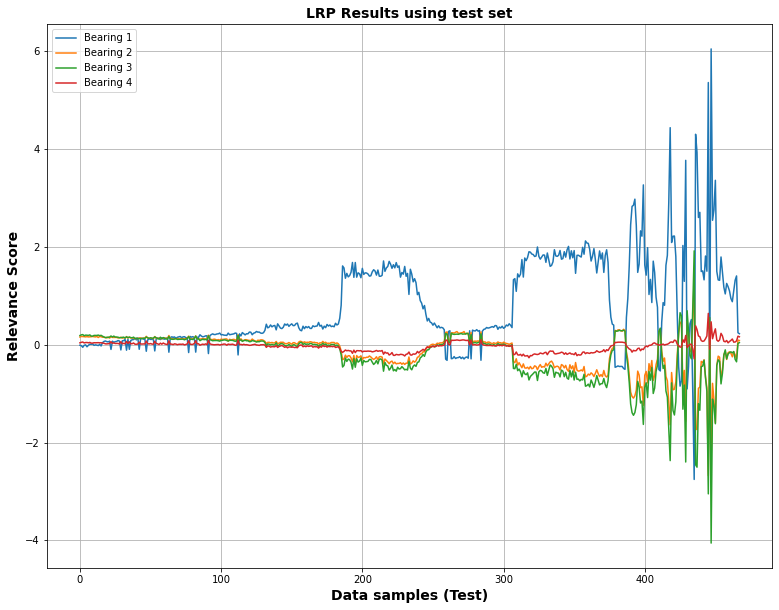

In [14]:
feature = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']
plt.figure(figsize=(13,10))
plt.plot(explanations)
plt.legend(labels=feature)
plt.title("LRP Results using test set", fontsize=14, fontweight='bold')
plt.xlabel("Data samples (Test)", fontsize=14, fontweight='bold')
plt.ylabel("Relevance Score", fontsize=14, fontweight='bold')
plt.grid()
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

[0.1469883  0.12596839 0.11495788 0.00633958]


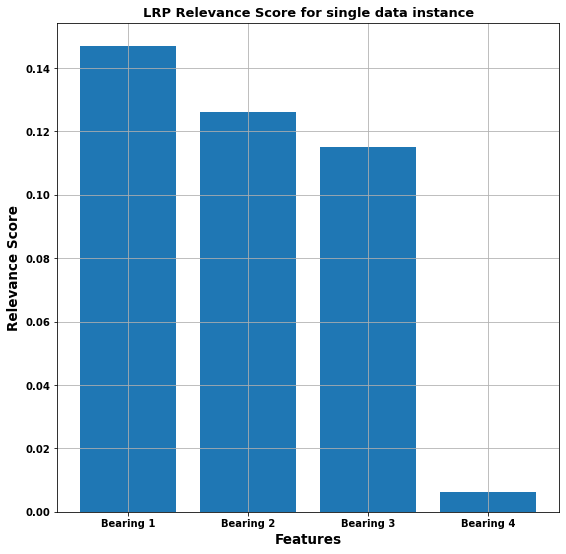

In [18]:
print(explanations[75])
features = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']
plt.figure(figsize=(9,9))
plt.title("LRP Relevance Score for single data instance", fontsize=13, fontweight='bold')
plt.bar(features, explanations[75])
plt.xlabel("Features", fontsize=13.5, fontweight='bold')
plt.ylabel("Relevance Score", fontsize=13.5, fontweight='bold')
plt.grid()
plt.show()

### Issues with LRP Implementation

The major issues when using LRP implementation are listed below:

### Doesn't fit for any uni-directional LSTM models

1. From the above implementation, it is pretty evident that this LRP implementation works for bi-directional LSTM models but when it is applied to any `uni-directional LSTM` models, it does not fit.
2. Adding to it, it doesn't fit for every bi-directional model instead. The current implementation works with only the model with `single bi-directional LSTM layer and dense layer`. If additional layers are added, then the dimension of weight matrix changes and it throws an `assertion error` as below.

In [117]:
lrp_lstm_model = tf.keras.models.load_model('models/anomaly_detection_model.h5')
lrp_lstm_model.summary()
weights_uni_lstm = weight_params(lrp_lstm_model)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 4)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 16)             1344      
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 68        
Total params: 1,412
Trainable params: 1,412
Non-trainable params: 0
_________________________________________________________________
Length of Weight matrix: 5
(4, 64)
(16, 64)
(64,)
(16, 4)
(4,)


In [89]:
#LRP Implementation for unidirectional LSTM
n_hidden = 4
input_dim = 4
n_classes = 4

lrp_model = LSTM_network(n_hidden, input_dim, n_classes, weights=weights_lstm)

AssertionError: 

### Wrap-up

1. LRP `fits` for `LSTM regression models` trained using time series data for anomaly detection.
2. But, the current LRP implementation is limited to `bi-directional LSTM model with only a dense layer`.
3. As of now, it does not fit for any other models `(uni-directional LSTM, encoder-decoder based, multiple bi-directional LSTM layers)`.
4. Current implementation can be `extended` to support the above model configuration but it is time consuming as this implementation is manual. But it can be done as a `future step`.

### References

[1] https://github.com/alewarne/Layerwise-Relevance-Propagation-for-LSTMs <br>
[2] https://colah.github.io/posts/2015-08-Understanding-LSTMs/ <br>
[3] https://www.kaggle.com/vinayak123tyagi/bearing-dataset